Commonly used in the field of recommendation systems.  
It means that when a function of two variables is fixed to any one independent variable,the function is linear with respect to another independent variable.

**Matrix factorization, MF**. is a commonly used model for **rating prediction** in recommender systems, whose task is to predict users' ratings of other goods based on their existing rating.   


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

data = np.loadtxt('movielens_100k.csv', delimiter=',', dtype=int)
print("size of dataset:", len(data))
# Both the user and movies are numbered from 1, convert to 0
data[:, :2] = data[:, :2] - 1

users = set()
items = set()
for i, j, k in data:
    users.add(i)
    items.add(j)
user_num = len(users)
item_num = len(items)
print(f"the number of user: {user_num} \nthe number of movies:{item_num}")

np.random.seed(0)
ratio = 0.8
split = int(len(data) * ratio)
np.random.shuffle(data)
train = data[:split]
test = data[split:]

# Statistical training sets the number of per user and movie as a regularized weight
user_cnt = np.bincount(train[:, 0], minlength=user_num)
item_cnt = np.bincount(train[:, 1], minlength=item_num)
print(user_cnt[:10])
print(item_cnt[:10])

user_train, user_test = train[:, 0], test[:, 0]
item_train, item_test = train[:, 1], test[:, 1]
y_train, y_test = train[:, 2], test[:, 2]

size of dataset: 100000
the number of user: 943 
the number of movies:1682
[215  47  42  19 139 170 320  47  18 156]
[371 109  70 172  70  21 308 158 240  68]


In [2]:
class MF:
    def __init__(self, N, M, d):
        # N:user_num, M:item_num, d:feature dimension
        # Define model parameters
        self.user_params = np.ones((N, d))
        self.item_params = np.ones((M, d))
        
    def pred(self, user_id, item_id):
        # Predicts user's rating of the movie item
        # Get user preferences and movie features
        user_param = self.user_params[user_id]
        item_param = self.item_params[item_id]
        
        rating_pred = np.sum(user_param * item_param, axis=1)
        return rating_pred
    
    def update(self, user_grad, item_grad, lr):
        self.user_params -= lr * user_grad
        self.item_params -= lr * item_grad

In [4]:
def train(model, learning_rate, lbd, max_training_step, batch_size):
    train_losses = []
    test_losses = []
    batch_num = int(np.ceil(len(user_train) / batch_size))
    with tqdm(range(max_training_step * batch_num)) as pbar:
        for epoch in range(max_training_step):
            # Stochastic gradient descent
            train_rmse = 0
            for i in range(batch_num):
                # gets the current batch
                st = i * batch_size
                ed = min(len(user_train), st + batch_size)
                user_batch = user_train[st: ed]
                item_batch = item_train[st: ed]
                y_batch = y_train[st: ed]
                # Computational model prediction
                y_pred = model.pred(user_batch, item_batch)
                # Calculate gradient
                P = model.user_params
                Q = model.item_params
                errs = y_batch - y_pred
                P_grad = np.zeros_like(P)
                Q_grad = np.zeros_like(Q)
                for user, item, err in zip(user_batch, item_batch, errs):
                    P_grad[user] = P_grad[user] - err * Q[item] + lbd * P[user]
                    Q_grad[item] = Q_grad[item] - err * P[user] + lbd * Q[item]
                model.update(P_grad / len(user_batch), Q_grad / len(user_batch), learning_rate)
                
                train_rmse += np.mean(errs ** 2)
                # update progress bar
                pbar.set_postfix({
                    'Epoch:': epoch,
                    'Train RMSE': f'{np.sqrt(train_rmse / (i + 1)):.4f}',
                    'Test RMSE': f'{test_losses[-1]:.4f}' if test_losses else None
                })
                pbar.update(1)
                
            # calculate the RMSE in test set
            train_rmse = np.sqrt(train_rmse / len(user_train))
            train_losses.append(train_rmse)
            y_test_pred = model.pred(user_test, item_test)
            test_rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
            test_losses.append(test_rmse)
            
    return train_losses, test_losses

100%|███████████████████| 37500/37500 [02:17<00:00, 272.47it/s, Epoch:=29, Train RMSE=0.9673, Test RMSE=1.0048]


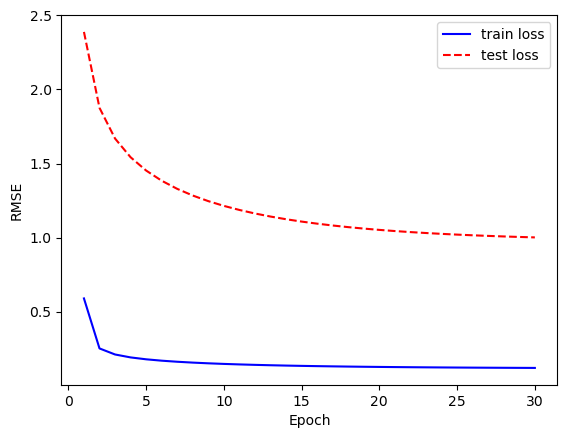

In [7]:
# 超参数
feature_num = 16 # 特征数
learning_rate = 0.1 # 学习率
lbd = 1e-4 # 正则化强度
max_training_step = 30
batch_size = 64 # 批量大小

# 建立模型
model = MF(user_num, item_num, feature_num)
# 训练部分
train_losses, test_losses = train(model, learning_rate, lbd,
    max_training_step, batch_size)

plt.figure()
x = np.arange(max_training_step) + 1
plt.plot(x, train_losses, color='blue', label='train loss')
plt.plot(x, test_losses, color='red', ls='--', label='test loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [6]:
y_test_pred = model.pred(user_test, item_test)
print(y_test_pred[:10]) # 把张量转换为numpy数组
print(y_test[:10])

[2.57712395 3.48622005 3.76150216 3.58604004 4.8058418  3.47284112
 3.37246031 4.0917956  3.02605747 3.45742155]
[2 4 4 4 5 2 3 1 4 4]
